<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/inpainting_landscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is a GUI for removing object in the foreground and obtain images containing only the background landscape
---
###Please ensure you have downloaded the required data from Figshare before proceeding.

**Google Colab:**



*   Upload the data to your Google Drive.
*   Select Google Drive in the widget below and mount your drive for the fastest access.




**Kaggle:**

*   Add the dataset to your notebook's Input directory (e.g., ../input/dataset-name).

*   Select Kaggle Input in the widget below.

**Local Computer:**

*   Store the downloaded files in a folder on your machine.

*   Select Local Storage in the widget below and paste the absolute path to that folder (e.g., /Users/name/data/).

In [ ]:
!pip install -U diffusers transformers accelerate

In [ ]:
import torch
from diffusers import DiffusionPipeline
from diffusers.utils import load_image

# switch to "mps" for apple devices
pipe = DiffusionPipeline.from_pretrained("sd2-community/stable-diffusion-2-inpainting", dtype=torch.bfloat16, device_map="cuda")


In [4]:

#--- Imports ---
import os
import time
from pathlib import Path
import pandas as pd
import zipfile
import urllib.request
from PIL import Image
import numpy as np
import cv2
import torch
!pip install git+https://github.com/openai/CLIP.git
import clip
from diffusers import StableDiffusionInpaintPipeline
from tqdm import tqdm
import threading
from IPython.display import display
import ipywidgets as widgets


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ye4rly4f
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ye4rly4f
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=0ae677e5f71a66a73723a4a4d3925021d098e7dce1c063d132310a5787b8fff0
  Stored in directory: /tmp/pip-ephem-wheel-cache-uysfa0fk/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [5]:

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
for p in clip_model.parameters():
    p.requires_grad_(False)

txt_feat_nat = clip_model.encode_text(clip.tokenize("a natural landscape").to(device))
txt_feat_sal = clip_model.encode_text(clip.tokenize("a landscape with an object at the center").to(device))
txt_feat_nat /= txt_feat_nat.norm(dim=-1, keepdim=True)
txt_feat_sal /= txt_feat_sal.norm(dim=-1, keepdim=True)

POS_PROMPT = "empty landscape, photorealistic, consistent lighting, high detail, outdoor, natural scene"
NEG_PROMPT = "object, animal, person, vehicle, table, text, logo, watermark, focal subject, centered object, unrealistic"
#--- Function to inpaint a single filename ---
def inpaint_image(fname, n_candidates=3):
    # Ensure we find the row for the specific filename using the new column
    row_query = meta.query("extracted_filename == @fname")
    if row_query.empty:
        with out: # Keep essential warning in GUI output
            print(f"Warning: Metadata not found for {fname}. Skipping inpainting.")
        return None
    row = row_query.iloc[0]

    # Get the DataFrame for the object to build the mask - using f-string for query
    query_str = f"object_name == '{row.object_name}' and rxz == {row.rxz}"
    df_obj = meta.query(query_str)

    mask = build_static_mask(df_obj)
    img = Image.open(EXTRACT_DIR / fname).convert("RGB")
    best_img, best_score = None, -float('inf')
    for i in tqdm(range(n_candidates), desc=f"Inpainting {fname}"):
        # Removed verbose output: with out: print(f"  Processing candidate {i+1}/{n_candidates}")
        seed = int(time.time_ns()) & 0xFFFFFFFF
        gen = torch.Generator(device).manual_seed(seed)
        out_pipe = pipe( # Renamed variable to avoid conflict with output widget
            prompt=POS_PROMPT,
            negative_prompt=NEG_PROMPT,
            image=img,
            mask_image=mask,
            num_inference_steps=30,
            guidance_scale=4.5,
            strength=1.0,
            generator=gen,
        )
        candidate = out_pipe.images[0]
        score_nat = clip_similarity(clip_model, clip_preprocess, candidate, txt_feat_nat)
        score_sal = clip_similarity(clip_model, clip_preprocess, candidate, txt_feat_sal)
        ratio = score_nat / (score_sal + 1e-6)
        if ratio > best_score:
            best_score = ratio
            best_img = candidate

    # Save inpainted
    INPAINT_DIR = DATA_DIR / "inpainted_images"
    INPAINT_DIR.mkdir(parents=True, exist_ok=True)
    out_path = INPAINT_DIR / fname
    if best_img: # Check if a valid image was found
        try:
            best_img.convert("L").save(out_path, format='PNG') # Explicitly specify format
            # Add check after saving
            if out_path.exists() and out_path.stat().st_size > 0:
                 with out:
                     print(f"Successfully saved inpainted image to {out_path}")
                 return True # Indicate success
            else:
                 with out:
                     print(f"Warning: Inpainted image file {out_path} was not created or is empty.")
                 return False # Indicate failure
        except Exception as e:
            with out:
                print(f"Error saving inpainted image {out_path}: {e}")
            return False # Indicate failure
        # Removed verbose output: with out: print(f"Finished inpainting for {fname}. Saved to {out_path}")
    else:
        with out: # Keep essential failure message in GUI output
            print(f"Failed to generate a valid image for {fname}")
        return False # Indicate failure
#--- Function to start background inpainting for all missing images ---
def start_batch_inpainting(update_display_func, current_index):
    # Get the list of filenames that have metadata and are in the extracted directory
    extracted_filenames_set = sorted(set(f.name for f in EXTRACT_DIR.glob("*.png")))
    filenames_with_metadata = [fname for fname in meta['extracted_filename'] if fname in extracted_filenames_set]

    # Get the list of already inpainted filenames
    inpainted_filenames_set = sorted(set(f.name for f in INPAINT_DIR.glob("*.png")))

    # Identify filenames that need inpainting
    to_inpaint = [fname for fname in filenames_with_metadata if fname not in inpainted_filenames_set]

    if not to_inpaint:
        with out:
            print("All images with metadata have already been inpainted.")
        return

    with out:
        print(f"Starting background inpainting for {len(to_inpaint)} missing images...")

    # Function to run in the background thread
    def inpaint_missing_images_thread(filename_list, update_display_func, current_index):
        for fname in filename_list:
            success = inpaint_image(fname)
            if success:
                # Update the GUI display after each image is processed
                # Add a small delay to avoid overwhelming the GUI with rapid updates
                time.sleep(0.1) # Added small delay
                # Only update the display if we are on the current image or a subsequent one
                global filenames # Access the global filenames list
                filenames = sorted(
                    set(f.name for f in EXTRACT_DIR.glob("*.png")) &
                    set(f.name for f in INPAINT_DIR.glob("*.png"))
                )
                if filenames and fname in filenames[current_index:]:
                     update_display_func(current_index)


    # Start the background thread
    threading.Thread(target=lambda: inpaint_missing_images_thread(to_inpaint, update_display_func, current_index), daemon=True).start()

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 191MiB/s]


In [ ]:
# ──────────────────────────────────────────────────────────────────────
# DATA SETUP WIDGET (Universal: Colab, Kaggle & Local)
# ──────────────────────────────────────────────────────────────────────
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import shutil
from pathlib import Path
# --- 1. CONFIGURATION
REQUIRED_FILES = [
    'hvm_public_extended_meta.csv',
    'background_variations_images.zip'
]
DEST_DIR = Path("downloads")
DEST_DIR.mkdir(exist_ok=True)

# Detect Environment
IN_COLAB = 'google.colab' in str(get_ipython())
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

# --- UI Elements ---
style = {'description_width': '120px'}
layout_full = widgets.Layout(width='98%')

header = widgets.HTML("<h2>📂 Data Import Manager</h2>")

# Determine options based on environment
options = ['Local Upload']
if IN_COLAB:
    options = ['Google Drive', 'Local Upload']
elif IN_KAGGLE:
    options = ['Kaggle Input', 'Local Upload']
else:
    options = ['Local Storage', 'Local Upload']

source_toggle = widgets.ToggleButtons(
    options=options,
    description='Select Source:',
    button_style='info',
    style=style
)

# Input for Paths
path_input = widgets.Text(
    value='/content/drive/MyDrive/vlPFC_Geometry' if IN_COLAB else '.',
    placeholder='Enter absolute path to data folder...',
    description='Data Path:',
    disabled=False,
    layout=layout_full,
    style=style
)

btn_action = widgets.Button(
    description='Start Import',
    button_style='primary',
    icon='download',
    layout=widgets.Layout(width='200px')
)

out_log = widgets.Output(layout={'border': '1px solid #ddd', 'padding': '10px'})

# --- Logic ---
def update_ui(change):
    if source_toggle.value == 'Local Upload':
        path_input.layout.display = 'none'
    else:
        path_input.layout.display = 'flex'
        if source_toggle.value == 'Google Drive':
            path_input.description = 'Drive Path:'
        elif source_toggle.value == 'Local Storage':
            path_input.description = 'Local Path:'
        elif source_toggle.value == 'Kaggle Input':
            path_input.description = 'Input Path:'
            path_input.value = '/kaggle/input/vlpfc-geometry'

source_toggle.observe(update_ui, 'value')

def on_click_action(b):
    with out_log:
        clear_output()
        mode = source_toggle.value

        if mode == 'Local Upload':
            if IN_COLAB:
                from google.colab import files
                print("🚀 Upload files now (select all required files):")
                uploaded = files.upload()
                for name in uploaded:
                    shutil.move(name, DEST_DIR / name)
                print("\n✅ Upload complete.")
            else:
                print("⚠️ Manual upload widget is Colab-only.")
                print(f"👉 Please manually copy files to: {DEST_DIR.absolute()}")
            return

        src_path = Path(path_input.value)
        if mode == 'Google Drive' and not src_path.exists():
            from google.colab import drive
            print("🔄 Mounting Google Drive...")
            drive.mount('/content/drive')

        if not src_path.exists():
            print(f"❌ Error: Path not found: {src_path}")
            return

        print(f"🔎 Scanning {src_path} for files...")
        for fname in REQUIRED_FILES:
            dest = DEST_DIR / fname
            if dest.exists():
                print(f"   • {fname}: Already exists (Skipping)")
                continue

            found = list(src_path.rglob(fname))
            if found:
                print(f"   • Copying {fname}...", end=" ")
                shutil.copy(found[0], dest)
                print("Done.")
            else:
                print(f"   ❌ {fname}: Not found in source path.")

        missing = [f for f in REQUIRED_FILES if not (DEST_DIR / f).exists()]
        if not missing:
            print("\n🎉 Success! All files are in 'downloads/'. Run the next cell.")
        else:
            print(f"\n⚠️ Missing files: {missing}")

update_ui(None)
btn_action.on_click(on_click_action)
display(header, source_toggle, path_input, btn_action, out_log)
from pathlib import Path

# make sure DATA_DIR is still pointing at where you unzipped
if IN_KAGGLE:
    DATA_DIR     = Path("/kaggle/working/data")
else:
    DATA_DIR     = Path("data")
EXTRACT_DIR  = DATA_DIR / "background_variations_images"
INPAINT_DIR  = DATA_DIR / "inpainted_images"

# (re-create the dirs if you like, though they should already exist)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
INPAINT_DIR.mkdir(parents=True, exist_ok=True)

# now collect the intersection of the two sets of PNGs
filenames = sorted(
    set(f.name for f in EXTRACT_DIR.glob("*.png")) &
    set(f.name for f in INPAINT_DIR.glob("*.png"))
)
index = 0


In [8]:
import sys
# detect environment
IN_COLAB   = 'google.colab' in str(get_ipython())
IN_KAGGLE  = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

# choose clone location
if IN_COLAB:
    path_to_repo = Path('/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex')
elif IN_KAGGLE:
    path_to_repo = Path('/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex')
else:
    path_to_repo = Path('.')  # your local git clone

# clone if necessary
if not path_to_repo.exists():
    print(f"Cloning into {path_to_repo}…")
    os.system(f"git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git {path_to_repo}")

# add to path
sys.path.append(str(path_to_repo))
sys.path.append(str(path_to_repo / 'utils'))

from extract_and_download_data import unzip

# Metadata check
DOWNLOAD_DIR = Path("downloads")
if not (DOWNLOAD_DIR / "hvm_public_extended_meta.csv").exists():
    print("Warning: Metadata file not found in downloads/.")

# Extract images
DATA_DIR = Path("data")
EXTRACT_DIR = DATA_DIR / "background_variations_images"
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

zip_path = DOWNLOAD_DIR / "background_variations_images.zip"
if zip_path.exists():
    unzip(str(zip_path), EXTRACT_DIR)
else:
    print(f"Warning: {zip_path} not found.")

# Add a check to see if files were extracted
if not any(EXTRACT_DIR.iterdir()):
    print(f"Warning: No files found in {EXTRACT_DIR}. Extraction may have failed.")
#--- Load stimulus metadata ---
if IN_KAGGLE:
    meta = pd.read_csv("/kaggle/working/downloads/hvm_public_extended_meta.csv")
else:
    meta = pd.read_csv("downloads/hvm_public_extended_meta.csv")
# Add a new column for the actual filenames in the extracted directory
meta['extracted_filename'] = meta['image_id'] + '.png'


Unzipping downloads/background_variations_images.zip...
Unzip successful.


In [13]:

#--- Inpainting helper functions (from inpainting.py) ---
def stack_object_images(df_obj, convert_gray=True, max_images=None):
    pixels = []
    for i, fname in enumerate(df_obj.filename):
        if max_images is not None and i >= max_images:
            break
        img_path = EXTRACT_DIR / fname
        if not img_path.exists():
            continue
        im = Image.open(img_path)
        if convert_gray:
            im = im.convert("L")
        pixels.append(np.asarray(im, dtype=np.uint8))
    return np.stack(pixels, axis=0)

def clip_similarity(clip_model, clip_preprocess, img, txt_feat):
    with torch.no_grad():
        img_tensor = clip_preprocess(img).unsqueeze(0).to(device)
        feat = clip_model.encode_image(img_tensor)
        feat /= feat.norm(dim=-1, keepdim=True)
    return (feat @ txt_feat.T).item()


# GUI

In [ ]:
import threading
import time
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- 1. THREAD SAFETY & FIXES ---

# Create a Lock to prevent the AI from crashing if two requests happen at once
pipe_lock = threading.Lock()

# Global flag to stop any old background threads from previous cell runs
STOP_THREADS = True
time.sleep(1) # Give old threads a moment to stop
STOP_THREADS = False

# mask builder
def build_static_mask(df_obj, variance_thr=5, dilate_px=0, feather_px=12):
    img_stack = stack_object_images(df_obj)
    ptp = img_stack.max(axis=0) - img_stack.min(axis=0)
    static = (ptp < variance_thr).astype(np.uint8)
    bbox = (
        int(df_obj.axis_bb_left.min()),
        int(df_obj.axis_bb_top.min()),
        int(df_obj.axis_bb_right.max()),
        int(df_obj.axis_bb_bottom.max()),
    )
    mask = np.zeros_like(static, dtype=np.uint8)
    x1, y1, x2, y2 = bbox
    mask[y1:y2, x1:x2] = static[y1:y2, x1:x2]
    mask = cv2.dilate(mask, None, iterations=dilate_px//2 or 1)
    mask = cv2.GaussianBlur(mask.astype(np.float32), (0,0), feather_px)
    mask = (mask / mask.max() * 255).astype(np.uint8)
    # FIX: Removed mode="L" to stop warning
    return Image.fromarray(mask)

# Redefine inpaint_image to be THREAD-SAFE
def safe_inpaint_image(fname, n_candidates=3):
    # Ensure metadata exists
    row_query = meta.query("extracted_filename == @fname")
    if row_query.empty:
        return False
    row = row_query.iloc[0]

    # Build mask
    query_str = f"object_name == '{row.object_name}' and rxz == {row.rxz}"
    df_obj = meta.query(query_str)
    mask = build_static_mask(df_obj)

    img_path = EXTRACT_DIR / fname
    if not img_path.exists(): return False
    img = Image.open(img_path).convert("RGB")

    best_img, best_score = None, -float('inf')

    # CRITICAL: Lock the GPU so no other thread can interrupt this loop
    with pipe_lock:
        for i in range(n_candidates):
            seed = int(time.time_ns()) & 0xFFFFFFFF
            gen = torch.Generator(device).manual_seed(seed)
            out_pipe = pipe(
                prompt=POS_PROMPT,
                negative_prompt=NEG_PROMPT,
                image=img,
                mask_image=mask,
                num_inference_steps=30,
                guidance_scale=4.5,
                strength=1.0,
                generator=gen,
            )
            candidate = out_pipe.images[0]
            score_nat = clip_similarity(clip_model, clip_preprocess, candidate, txt_feat_nat)
            score_sal = clip_similarity(clip_model, clip_preprocess, candidate, txt_feat_sal)
            ratio = score_nat / (score_sal + 1e-6)
            if ratio > best_score:
                best_score = ratio
                best_img = candidate

    # Save
    INPAINT_DIR = DATA_DIR / "inpainted_images"
    INPAINT_DIR.mkdir(parents=True, exist_ok=True)
    out_path = INPAINT_DIR / fname
    if best_img:
        best_img.convert("L").save(out_path, format='PNG')
        return True
    return False

# --- 2. IMPROVED GUI ---

# State Variables
gui_filenames = []
gui_index = 0

# Widgets
w_progress = widgets.IntProgress(description='Queue:', min=0, max=100, bar_style='info', layout=widgets.Layout(width='98%'))
w_status = widgets.Label(value="Status: Idle")
w_out_img = widgets.Output()
w_btn_prev = widgets.Button(description='⟵ Prev')
w_btn_next = widgets.Button(description='Next ⟶')
w_btn_del = widgets.Button(description='Delete & Retry', button_style='danger')
w_auto_refresh = widgets.Checkbox(value=True, description='Auto-Show New')

def update_file_list():
    global gui_filenames
    # Intersection of extracted and inpainted
    extracted = set(f.name for f in EXTRACT_DIR.glob("*.png"))
    inpainted = set(f.name for f in INPAINT_DIR.glob("*.png"))
    gui_filenames = sorted(extracted & inpainted)
    return gui_filenames

def show_image(idx):
    w_out_img.clear_output(wait=True)
    update_file_list()

    if not gui_filenames:
        with w_out_img: print("No inpainted images ready yet.")
        return

    # safe bounds
    safe_idx = max(0, min(idx, len(gui_filenames)-1))
    fname = gui_filenames[safe_idx]

    # Update global index to match what is shown
    global gui_index
    gui_index = safe_idx

    path_orig = EXTRACT_DIR / fname
    path_inp = INPAINT_DIR / fname

    if path_orig.exists() and path_inp.exists():
        img1 = Image.open(path_orig)
        img2 = Image.open(path_inp)

        # Serialize for display
        b1, b2 = io.BytesIO(), io.BytesIO()
        img1.save(b1, format='PNG')
        img2.save(b2, format='PNG')

        with w_out_img:
            display(widgets.HTML(f"<b>{safe_idx+1} / {len(gui_filenames)}</b>: {fname}"))
            display(widgets.HBox([
                widgets.Image(value=b1.getvalue(), width=350),
                widgets.Image(value=b2.getvalue(), width=350)
            ]))
    else:
        with w_out_img: print(f"File missing for {fname}")

# --- Event Handlers ---
def on_click_next(b):
    show_image(gui_index + 1)

def on_click_prev(b):
    show_image(gui_index - 1)

def on_click_del(b):
    if not gui_filenames: return
    fname = gui_filenames[gui_index]
    path = INPAINT_DIR / fname
    if path.exists():
        path.unlink() # Delete file

    w_status.value = f"Status: Regenerating {fname}..."
    # Run safe inpaint (blocking UI briefly is safer than crashing)
    safe_inpaint_image(fname)
    show_image(gui_index)
    w_status.value = "Status: Regenerated."

w_btn_next.on_click(on_click_next)
w_btn_prev.on_click(on_click_prev)
w_btn_del.on_click(on_click_del)

# --- 3. BACKGROUND WORKER ---
def background_worker():
    global STOP_THREADS

    while not STOP_THREADS:
        # Find work
        extracted = sorted(set(f.name for f in EXTRACT_DIR.glob("*.png")))
        meta_fnames = set(meta['extracted_filename'])
        valid = [f for f in extracted if f in meta_fnames]

        inpainted = set(f.name for f in INPAINT_DIR.glob("*.png"))
        todo = [f for f in valid if f not in inpainted]

        # Update Progress Bar
        w_progress.max = len(valid)
        w_progress.value = len(inpainted)

        if not todo:
            w_status.value = "Status: ✅ All background images completed."
            time.sleep(2)
            continue

        # Do work
        target = todo[0]
        w_status.value = f"Status: Inpainting {target} ({len(todo)} left)..."

        try:
            success = safe_inpaint_image(target)
            if success and w_auto_refresh.value:
                # If we are viewing the "Wait" screen, refresh immediately
                if len(gui_filenames) == 0:
                     show_image(0)
        except Exception as e:
            print(f"Worker Error: {e}")

    print("Background thread stopped.")

# --- 4. LAUNCH ---
threading.Thread(target=background_worker, daemon=True).start()

# Layout
ui = widgets.VBox([
    widgets.HTML("<h3>🎨 Inpainting Dashboard</h3>"),
    widgets.HBox([w_status, w_auto_refresh]),
    w_progress,
    widgets.HBox([w_btn_prev, w_btn_del, w_btn_next]),
    w_out_img
])

display(ui)
show_image(0)

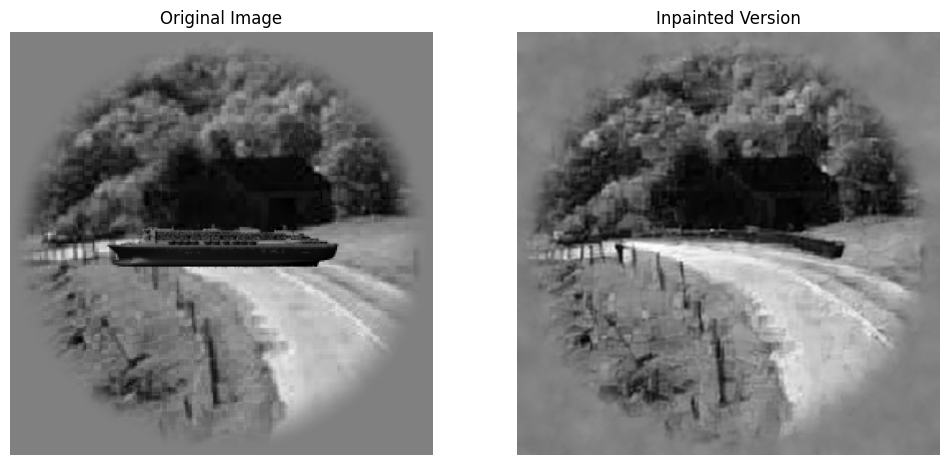

In [21]:
import matplotlib.pyplot as plt
index = np.random.randint(0, len(filenames))
if filenames and 0 <= index < len(filenames):
    fname = filenames[index]
    orig_path = EXTRACT_DIR / fname
    inp_path = INPAINT_DIR / fname

    if orig_path.exists() and inp_path.exists():
        orig_img = Image.open(orig_path)
        inp_img = Image.open(inp_path)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(orig_img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(inp_img, cmap='gray') # Added cmap='gray' for explicit grayscale display
        plt.title('Inpainted Version')
        plt.axis('off')

        plt.show()
    else:
        print(f"Error: Image files not found for {fname}. Original: {orig_path.exists()}, Inpainted: {inp_path.exists()}")
else:
    print("No images available to plot or index is out of bounds.")